In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

In [2]:
import logging
import string
import sys
import os
import pandas as pd
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from src.figure_utilities import (
    PAGE_HEIGHT,
    ONE_COLUMN,
    TWO_COLUMN,
    save_figure,
    set_figure_defaults,
)

set_figure_defaults()

In [6]:
from glob import glob
import os
import pandas as pd
from src.parameters import PROCESSED_DATA_DIR, STATE_COLORS, STATE_ORDER
from src.figure_utilities import TWO_COLUMN, PAGE_HEIGHT, save_figure
import seaborn as sns
import matplotlib.pyplot as plt
from src.visualization import (
    plot_category_counts,
    plot_category_duration,
    plot_linear_position_markers,
)

from loren_frank_data_processing import make_tetrode_dataframe
from src.parameters import ANIMALS, STATE_ORDER, _BRAIN_AREAS

tetrode_info = make_tetrode_dataframe(ANIMALS)

data_type, dim = "clusterless", "1D"
n_unique_spiking = 2

file_paths = glob(
    os.path.join(
        PROCESSED_DATA_DIR, f"*_{data_type}_{dim}_no_interneuron_replay_info_80.csv"
    )
)
replay_info = pd.concat(
    [pd.read_csv(file_path) for file_path in file_paths], axis=0,
).set_index(["animal", "day", "epoch", "ripple_number"])
replay_info = replay_info.loc[
    replay_info.n_unique_spiking >= n_unique_spiking
].sort_index()

is_brain_areas = tetrode_info.area.astype(str).str.upper().isin(_BRAIN_AREAS)
n_tetrodes = (
    tetrode_info.loc[is_brain_areas]
    .groupby(["animal", "day", "epoch"])
    .tetrode_id.count()
    .rename("n_tetrodes")
)
replay_info = pd.merge(
    replay_info.reset_index(), pd.DataFrame(n_tetrodes).reset_index()
).set_index(["animal", "day", "epoch", "ripple_number"])

for state in STATE_ORDER:
    replay_info[f"{state}_pct_unique_spiking"] = (
        replay_info[f"{state}_n_unique_spiking"] / replay_info["n_tetrodes"]
    )
replay_info = replay_info.rename(index={"Cor": "cor"}).rename_axis(
    index={"animal": "Animal ID"}
)
replay_info.head()

Continuous  Continuous_Cont_avg_prob  \
Animal ID day epoch ripple_number                                         
cor       1   2     1                   False                       NaN   
                    2                   False                       NaN   
                    3                   False                       NaN   
                    4                    True                  0.950692   
                    5                   False                       NaN   

                                   Continuous_Frag_avg_prob  \
Animal ID day epoch ripple_number                             
cor       1   2     1                                   NaN   
                    2                                   NaN   
                    3                                   NaN   
                    4                               0.00904   
                    5                                   NaN   

                                   Continuous_Hov_avg_prob  \
Animal ID day epoch ripple_number                            
cor       1   2     1                                  NaN   
                    2                                  NaN   
                    3                                  NaN   
                    4                             0.040268   
                    5                                  NaN   

                                   Continuous_duration  \
Animal ID day epoch ripple_number                        
cor       1   2     1                            0.000   
                    2                            0.000   
                    3                            0.000   
                    4                            0.078   
                    5                            0.000   

                                   Continuous_fraction_of_time  \
Animal ID day epoch ripple_number                                
cor       1   2     1                                 0.000000   
                    2                                 0.000000   
                    3                                 0.000000   
                    4                                 0.886364   
                    5                                 0.000000   

                                   Continuous_max_probability  \
Animal ID day epoch ripple_number                               
cor       1   2     1                                0.433041   
                    2                                0.145397   
                    3                                0.253315   
                    4                                0.984098   
                    5                                0.471431   

                                   Continuous_max_ripple_consensus_trace_zscore  \
Animal ID day epoch ripple_number                                                 
cor       1   2     1                                                       NaN   
                    2                                                       NaN   
                    3                                                       NaN   
                    4                                                 11.407677   
                    5                                                       NaN   

                                   Continuous_max_time  \
Animal ID day epoch ripple_number                        
cor       1   2     1                              NaN   
                    2                              NaN   
                    3                              NaN   
                    4                            0.076   
                    5                              NaN   

                                   Continuous_mean_ripple_consensus_trace_zscore  \
Animal ID day epoch ripple_number                                                  
cor       1   2     1                                                        NaN   
                    2                                            

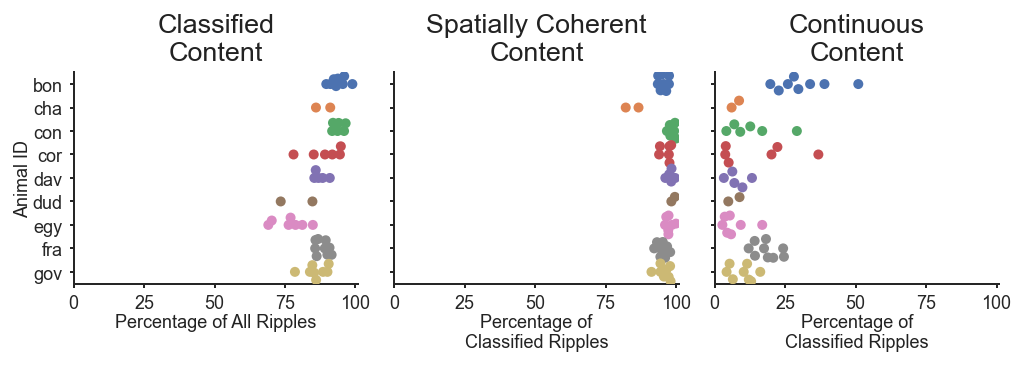

In [10]:
fig, axes = plt.subplots(
    1,
    3,
    figsize=(TWO_COLUMN, PAGE_HEIGHT / 4),
    sharex=True,
    sharey=True,
    constrained_layout=True,
)

# ax 0
df = pd.DataFrame(
    replay_info.groupby(["Animal ID", "day"])
    .apply(lambda df: (df["is_classified"]).mean() * 100)
    .rename("Percentage of All Ripples")
).reset_index()

sns.swarmplot(
    data=df, x="Percentage of All Ripples", y="Animal ID", ax=axes[0],
)
axes[0].set_title("Classified\nContent")

# ax 1
df = pd.DataFrame(
    replay_info.loc[replay_info.is_classified]
    .groupby(["Animal ID", "day"])
    .apply(
        lambda df: (df["Hover"] | df["Hover-Continuous-Mix"] | df["Continuous"]).mean()
        * 100
    )
    .rename("Percentage of Classified Ripples")
).reset_index()
sns.swarmplot(
    data=df, x="Percentage of Classified Ripples", y="Animal ID", ax=axes[1],
)
axes[1].set_ylabel("")
axes[1].set_xlabel("Percentage of\nClassified Ripples")
axes[1].set_title("Spatially Coherent\nContent")

# ax 2
df = pd.DataFrame(
    replay_info.groupby(["Animal ID", "day"])
    .apply(lambda df: (df["Continuous"]).mean() * 100)
    .rename("Percentage of Classified Ripples")
).reset_index()

sns.swarmplot(
    data=df, x="Percentage of Classified Ripples", y="Animal ID", ax=axes[2],
)
axes[2].set_xlabel("Percentage of\nClassified Ripples")
axes[2].set_ylabel("")
axes[2].set_title("Continuous\nContent")

plt.xlim((0, 101))

sns.despine()

In [11]:
from src.visualization import SHORT_STATE_NAMES
from src.parameters import SHORT_STATE_ORDER, STATE_ORDER
from upsetplot import UpSet


def plot_category_counts(replay_info):
    df = replay_info.rename(columns=SHORT_STATE_NAMES).set_index(
        SHORT_STATE_ORDER[::-1]
    )
    upset = UpSet(
        df,
        sort_sets_by=None,
        show_counts=False,
        subset_size="count",
        sort_by="cardinality",
        intersection_plot_elements=5,
    )
    ax_dict = upset.plot()
    n_classified = replay_info.is_classified.sum()
    _, intersect_max = ax_dict["intersections"].get_ylim()
    ax_dict["intersections"].set_yticks(n_classified * np.arange(0, 0.6, 0.1))
    ax_dict["intersections"].set_yticklabels(range(0, 60, 10))
    ax_dict["intersections"].set_ylabel(
        "Percentage\nof Ripples",
        ha="center",
        va="center",
        rotation="horizontal",
        labelpad=30,
    )
    ax_dict["intersections"].text(
        9, n_classified * 0.45, f"N = {n_classified}", zorder=1000, fontsize=9
    )

    ax_dict["totals"].set_xticks([0, 0.5 * n_classified])
    ax_dict["totals"].set_xticklabels([0, 50])
    ax_dict["totals"].set_xlabel("Marginal Percentage\nof Ripples")
    ax_dict["totals"].set_ylim([-0.5, 4.4])

    plt.suptitle("Most Common Combinations of Dynamics", fontsize=14, x=0.55, y=0.925)
    for i, color in enumerate(STATE_ORDER):
        rect = plt.Rectangle(
            xy=(0, i - 0.4),
            width=1,
            height=0.8,
            facecolor=STATE_COLORS[color],
            lw=0,
            zorder=0,
            alpha=0.25,
        )
        ax_dict["shading"].add_patch(rect)

    return ax_dict


ax_dict = plot_category_counts(replay_info.loc[replay_info.is_classified])

TypeError: __init__() got an unexpected keyword argument 'sort_sets_by'